In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])

In [3]:
customers.head()
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [4]:
current_date = transactions['TransactionDate'].max()

In [5]:
transaction_agg = transactions.groupby('CustomerID').agg(
    LastPurchaseDate=('TransactionDate', 'max'),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum'),
    AvgPrice=('Price', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    UniqueProducts=('ProductID', 'nunique')
).reset_index()

In [6]:
transaction_agg['AvgTransactionValue'] = transaction_agg['Monetary'] / transaction_agg['Frequency']
transaction_agg['AvgQuantityPerTransaction'] = transaction_agg['TotalQuantity'] / transaction_agg['Frequency']


In [7]:
merged = pd.merge(customers, transaction_agg, on='CustomerID', how='inner')
merged['Tenure'] = (merged['LastPurchaseDate'] - merged['SignupDate']).dt.days
merged['Recency'] = (current_date - merged['LastPurchaseDate']).dt.days

In [8]:
features = merged[[
    'Region', 'Tenure', 'Recency', 'Frequency', 'Monetary',
    'AvgPrice', 'TotalQuantity', 'UniqueProducts',
    'AvgTransactionValue', 'AvgQuantityPerTransaction'
]]
features

,Region,Tenure,Recency,Frequency,Monetary,AvgPrice,TotalQuantity,UniqueProducts,AvgTransactionValue,AvgQuantityPerTransaction
0,South America,846,55,5,3354.52,278.334000,12,5,670.904000,2.400000
1,Asia,1024,25,4,1862.74,208.920000,10,4,465.685000,2.500000
2,South America,170,125,4,2725.38,195.707500,14,4,681.345000,3.500000
3,South America,806,4,8,5354.88,240.636250,23,8,669.360000,2.875000
4,Asia,812,54,3,2034.24,291.603333,7,3,678.080000,2.333333
...,...,...,...,...,...,...,...,...,...,...
194,Europe,922,13,4,4982.88,416.992500,12,3,1245.720000,3.000000
195,Europe,647,0,3,1928.65,227.056667,9,3,642.883333,3.000000
196,Europe,950,84,2,931.83,239.705000,3,2,465.915000,1.500000
197,Europe,693,63,4,1979.28,250.610000,9,4,494.820000,2.250000


In [19]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Tenure', 'Recency', 'Frequency', 'Monetary','AvgPrice', 'TotalQuantity', 'UniqueProducts',
    'AvgTransactionValue', 'AvgQuantityPerTransaction']),('cat', OneHotEncoder(), ['Region'])
])

processed_data = preprocessor.fit_transform(features)
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Tenure', 'Recency', 'Frequency', 'Monetary',
                                  'AvgPrice', 'TotalQuantity', 'UniqueProducts',
                                  'AvgTransactionValue',
                                  'AvgQuantityPerTransaction']),
                                ('cat', OneHotEncoder(), ['Region'])])

In [15]:
db_scores, silhouette_scores = [], []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(processed_data)
    db_scores.append(davies_bouldin_score(processed_data, labels))
    silhouette_scores.append(silhouette_score(processed_data, labels))
    
db_scores

[np.float64(1.5661302233555787),
 np.float64(1.5762106069989004),
 np.float64(1.4826930308736095),
 np.float64(1.6119247074084684),
 np.float64(1.682060468715829),
 np.float64(1.8468035691162492),
 np.float64(1.748584875206277),
 np.float64(1.67766214619573),
 np.float64(1.6395861949442683)]

In [17]:
silhouette_scores

[np.float64(0.21513428932529638),
 np.float64(0.20528404940729078),
 np.float64(0.19916964269620982),
 np.float64(0.1654114333054703),
 np.float64(0.15202705042092043),
 np.float64(0.12652798152264494),
 np.float64(0.11364390268582013),
 np.float64(0.12943736825399765),
 np.float64(0.13233440389947662)]

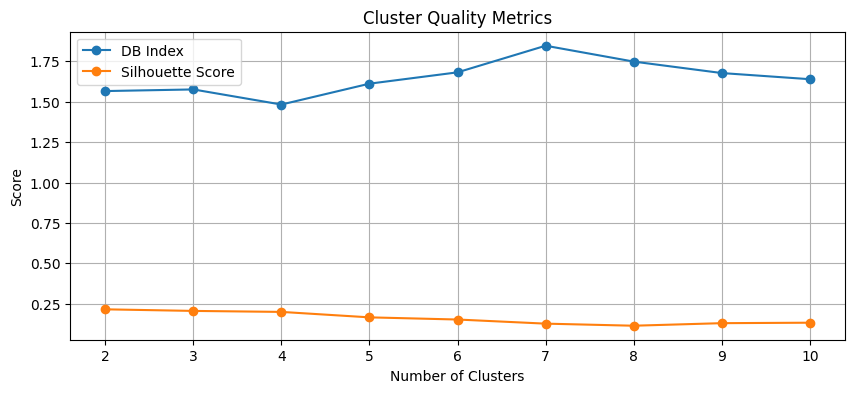

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(k_range, db_scores, marker='o', label='DB Index')
plt.plot(k_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters'), plt.ylabel('Score'), plt.legend()
plt.title('Cluster Quality Metrics'), plt.grid(True)
plt.show()

In [12]:
optimal_k = k_range[np.argmin(db_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(processed_data)

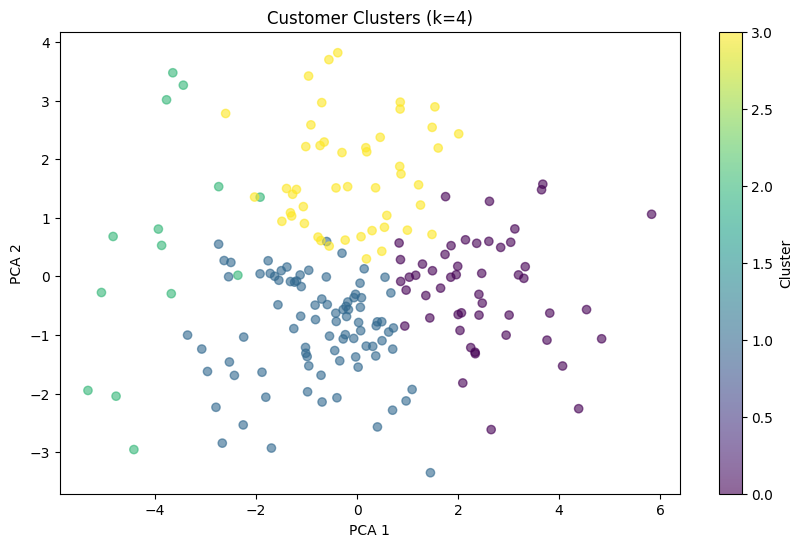

(<matplotlib.colorbar.Colorbar at 0x1ecad925c70>, None)

In [13]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(processed_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title(f'Customer Clusters (k={optimal_k})'), plt.xlabel('PCA 1'), plt.ylabel('PCA 2')
plt.colorbar(label='Cluster'), plt.show()

In [14]:
cluster_summary = merged.groupby(labels).agg({
    'Tenure': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AvgPrice': 'mean',
    'Region': lambda x: x.mode()[0]
}).reset_index()

print(f"Optimal Clusters: {optimal_k}")
print(f"DB Index: {db_scores[optimal_k-2]:.2f}")
print(f"Silhouette Score: {silhouette_scores[optimal_k-2]:.2f}")
print("\nCluster Summary:")
print(cluster_summary.round(2))

Optimal Clusters: 4
DB Index: 1.48
Silhouette Score: 0.20

Cluster Summary:
   index  Tenure  Recency  Frequency  Monetary  AvgPrice         Region
0      0  485.14    46.47       7.65   5707.71    273.82  South America
1      1  502.06    54.15       4.63   2416.32    241.29  South America
2      2  199.00   256.14       1.43    778.53    229.02           Asia
3      3  405.77    85.89       3.98   3782.62    338.64         Europe
